In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw,ImageFont
from matplotlib import cm

In [2]:
#classes dictionary 
classes_dict={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

In [3]:
#defintion of load_dataset()
def load_dataset():
    import csv
    with  open('C:\\Users\\Admin\\My Projects\\Emotion Recognition\\dataset\\fer2013.csv','r') as f:
        data=csv.reader(f)
        X=[]
        Y=[]
        i=1
        for row in data:
            if i:    #skip first row (header)
                i=0
                continue    
            Y.append(int(row[0]))
            X.append([int(n) for n in row[1].split(' ')])
    return (np.array(X),np.array(Y))

In [4]:
#load dataset from csv file
X,Y=load_dataset()

#normalizing the data
X=X/255

#reshape the data
X=X.reshape((X.shape[0],48,48,1))
Y=Y.reshape(Y.shape+(1,))

print(X.shape,Y.shape)

(35887, 48, 48, 1) (35887, 1)


In [5]:
#split the dataset into train and test 
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.08,random_state=0)

In [6]:
#converting the train and test labels into one-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train_oh=to_categorical(Y_train,len(classes_dict))
Y_test_oh=to_categorical(Y_test,len(classes_dict))

In [7]:
#definition of create_model()
def create_model():
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input,Conv2D,Dense,BatchNormalization,Activation
    from tensorflow.keras.layers import Dropout,MaxPooling2D,AveragePooling2D,Flatten

    inputs=Input(shape=(48,48,1))

    X=Conv2D(filters=32,kernel_size=(7,7),padding='same')(inputs)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=64,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)

    X=Conv2D(filters=128,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((2,2))(X)
    X=Dropout(.25)(X)  

    X=Conv2D(filters=256,kernel_size=(3,3),padding='same')(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=AveragePooling2D((6,6))(X) 
    X=Dropout(.25)(X)

    X=Flatten()(X)
    X=Dense(256)(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=Dropout(.25)(X)

    X=Dense(128)(X)
    X=BatchNormalization(axis=-1)(X)
    X=Activation('relu')(X)
    X=Dropout(.25)(X)

    X=Dense(7,'softmax')(X)

    model=Model(inputs=inputs,outputs=X)
    return model


In [8]:
#To train a model, set False to 'load_pretrained_model',otherwise pretrained model would be loaded 
##i strictly recommend train it on GPU system,otherwise it will take a lot of time,you can use either your GPU system or google
#colab with GPU
load_pretrained_model=True

if load_pretrained_model: 
    from tensorflow.keras.models import load_model 
    model=load_model('C:\\Users\\Admin\\My Projects\\Emotion Recognition\\Model\\model.h5')
    print('model is loaded successfully')
    
else:
    #create model with 4 conv layers and 2 FC layers
    model=create_model() 

    #compile the model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    #train the model
    num_iterations=114   
    model.fit(X_train,Y_train_oh,batch_size=64,epochs=num_iterations,validation_split=0.08,verbose=2)
    
    #save model  
    model.save('C:\\Users\\Admin\\My Projects\\Emotion Recognition\\Model\\Model.h5',save_format='h5')
    
    print('model is trained and saved successfully')

model is loaded successfully


In [9]:
#evaluate loss and accuracy on test set
loss,accuracy=model.evaluate(X_test,Y_test_oh)
print('Accuracy = ',accuracy)

2871/2871 [==============================] - 39s 14ms/sample - loss: 1.0629 - accuracy: 0.6660
Accuracy =  0.66597


Predicted class: Happy
Actual class:  Happy


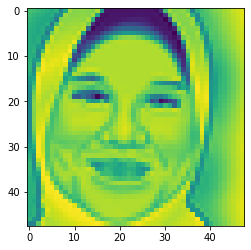

In [10]:
#prediction on test data
pred=model.predict(X_test)     #pred contain probabilty of each classe for each example
pred_class=np.argmax(pred,axis=1)  #one class index value for each example

index=0     #you try different index value to show prediction on different test example

print('Predicted class:',classes_dict[pred_class[index]])
print('Actual class: ',classes_dict[Y_test.squeeze()[index]])
plt.imshow(X_test[index].squeeze())

In [11]:
#definition of draw_boxes.Instead of this you can use cv2.rectangle() simpler and less interactive one to draw boxes
def draw_boxes(image,out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='C:\\Users\Admin\\My Projects\\Emotion Recognition\\font\\FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]

        label = predicted_class

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        #print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [12]:
#detect the emotions in single image
def Emotion_Detector(img):
    gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #detect faces in frame and return list of lacations of that faces
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.05,minNeighbors=20) 

    if len(faces)>0:
            boxes=[]
            pred=[]
            for (x,y,w,h) in faces:
                X=gray_img[y:y+h,x:x+w]
                X=cv2.resize(X,(48,48)) 
                #cv2.imshow('image',X)   
                X=X/255
                pred.append(model.predict(X.reshape((1,48,48,1))))  #list of probabilities of each classe for each face
                boxes.append((y,x,y+h,x+w))       #list contain location of faces

            boxes=np.array(boxes)  
            pred_classes=np.argmax(np.array(pred).squeeze(axis=1),axis=-1)

            img =Image.fromarray(img,'RGB') #convert numpy array object to image object

            #locate and label the faces with square box.Instead of this you can use cv2.rectangle() simpler and 
            #less interactive one to draw boxes 
            draw_boxes(img,boxes, pred_classes, classes_dict, colors_dict) 

            img=np.array(img)    #convert image object to array object 

    cv2.imshow('Emotion Detector',img)
    return img

In [13]:
def resize_img_if_big(img):
    return cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2))) if int(img.shape[1])>1500 else img


In [14]:
## now you can detect the emotions in Realtime Cam,Image and Video depend upon your choice,just run this cell and choose your choice 
import cv2
from tensorflow.keras.models import load_model

#colors(BGR) dictionary
colors_dict={0:(0,0,255),1:(0,255,255),2:(255,0,255),3:(0,255,0),4:(255,255,0),5:(255,0,0),6:(255,255,255)}

#extract face feature
face_cascade=cv2.CascadeClassifier('C:\\Users\\Admin\\My Projects\\Emotion Recognition\\HararCascade\\haarcascade_frontalface_default.xml')

print('choose option to detect emotions \n1.Realtime Cam \n2.Image \n3.Video')
ch=int(input('Enter your choice : '))

try:
    key=-1
    if ch==1:
        print('\nchoose cam \n1.WebCam \n2.IP Cam')
        ch=int(input('Enter your choice : '))
        try:
            flag=1
            if ch==1:
                #create video object
                video = cv2.VideoCapture(0)
            elif ch==2:    
                #create video object
                video = cv2.VideoCapture(input('Enter IP Cam url: '))     #IP Cam url like http://192.168.1.100:4343/video
            else:
                print('\nYou choosed wrong choice')
                flag=0
                
            if flag:
                print('\nPress q or Q to quit ')
                while True:
                        check, frame = video.read()
                        if check==False or key in [81,113]:
                            break
                        Emotion_Detector(frame)
                        key=cv2.waitKey(1) 
        finally: 
            video.release()

    elif ch==2:
        print('\nPress any key to quit ')
        path=input('Enter Path of your Image : ').replace('\\','\\\\')
        image = cv2.imread(path, 1)
        if np.size(image)==1:
            print('\nyou may entered wrong path')
        else:
            image=resize_img_if_big(image)
            image=Emotion_Detector(image)
            cv2.waitKey(0) 

    elif ch==3:
        path=input('\nEnter Path of your Video : ').replace('\\','\\\\')
        try:
            #create video object
            video = cv2.VideoCapture(path)
            key=-1
            while True:
                check, frame = video.read()
                if check==False or key in [81,113]:
                    if not check:
                        print('\nyou may entered wrong path')
                    break
                print('\nPress q or Q to quit ')    
                frame=resize_img_if_big(frame)
                Emotion_Detector(frame)
                key=cv2.waitKey(1) 
        finally: 
            video.release()
    else:
        print('\nYou choosed wrong choice')
finally:
    cv2.destroyAllWindows()
    

choose option to detect emotions 
1.Realtime Cam 
2.Image 
3.Video
Enter your choice : 1

choose cam 
1.WebCam 
2.IP Cam
Enter your choice : 1

Press q or Q to quit 


In [ ]:
#to save the emotion detected image
path='C:\\Users\\Admin\\My Projects\\Emotion Recognition\\prediction\\happy.jpg'
if cv2.imwrite(path,image):
    print('image is saved successfully')
else:
    print('image is not saved,enter a proper a path')  